Implement the origial [Nagel-Schreckenberg model of freeway traffic](https://en.wikipedia.org/wiki/Nagel%E2%80%93Schreckenberg_model):
1. Run the model for different probabilities $p$ of slowing down.
2. Plot the average velocity as a function of the density $\rho$ of cars per cell for different values of $p$.
3. Visualize the evolution of the system for $p = 0.3$ and $\rho = 0.1$, $0.2$, $0.6$.
4. (optional) Add a second lane (in the same direction) to the model and a rule that allows overtaking. Compare the results for the average velocity with the previous case.

In [235]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [236]:
class Car:
    def __init__(self, speed, max_speed):
        self.speed = speed
        self.max_speed = max_speed
    
    def __repr__(self):
        return f"Car(speed={self.speed})"

In [339]:
class PeriodicTrack:
    def __init__(self, array):
        self._array = array
        
    def __getitem__(self, index):
        index = self._wrap_index(index)
        return self._array.__getitem__(index)
    
    def __setitem__(self, index, value):
        index = self._wrap_index(index)
        return self._array.__setitem__(index, value)
    
    def __iter__(self):
        return self._array.__iter__()
    
    def __repr__(self):
        return self._array.__repr__()
    
    def __len__(self):
        return self._array.__len__()
    
    @staticmethod
    def random_track(length, n_cars, vmin=1, vmax=5):
        list_ = [None for _ in range(length)]
        indicies = random.sample(range(length), n_cars)
        for index in indicies:
            list_[index] = Car(random.randint(vmin, vmax), vmax)
        return PeriodicTrack(list_)
    
    @staticmethod
    def empty(length):
        return PeriodicTrack([None for _ in range(length)])
    
    def _wrap_index(self, index):
        _len = len(self._array)
        return (index % _len + _len) % _len
    
    def copy(self):
        return PeriodicTrack(self._array.copy())
    
    def distance_to_next_obj(self, index):
        dist = 0
        i = index + 1
        while self[i] is None:
            dist += 1
            i += 1
        return dist
    
    def plot(self):
        indices = [i for i, car in enumerate(self) if not car is None]
        speeds = [car.speed for car in self if not car is None]
        
        speeds_background = [car.speed if car is not None else 0 for car in self]
        plt.step(range(len(speeds_background)), speeds_background, where='mid', linestyle=':', color='black', alpha=0.7)
        plt.plot(indices, speeds, linestyle='', marker='*', markersize=15, color='gold', markeredgecolor='red')
        plt.ylim(0, 5.5)  # TMP
        plt.grid(alpha=0.3)
        plt.show()

In [331]:
def update_track(track):
    track = track.copy()
    new_track = PeriodicTrack.empty(len(track))
    for i, car in enumerate(track):
        if not car is None:
            car.speed = min(car.speed + 1, car.max_speed)  # Acceleration
            track[i] = Car(min(track.distance_to_next_obj(i), car.speed), car.max_speed)  #Slowing down
            # Randomization
    for i, car in enumerate(track):
        if not car is None:
            new_track[i + car.speed] = car
    return new_track

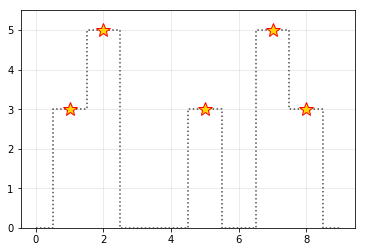

In [340]:
t1 = PeriodicTrack.random_track(10, 5)
t1.plot()

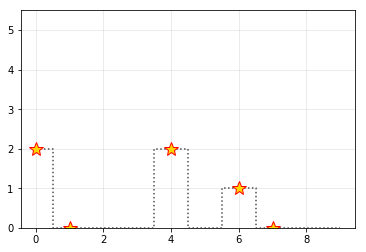

In [341]:
t2 = update_track(t1)
t2.plot()

In [163]:
next(i for i, _ in enumerate(t1) if isinstance(_, Car))

2

In [ ]:
class PeriodicTrack(np.ndarray):
    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj

    def __getitem__(self, index):
        index = self._wrap_index(index)
        return super(PeriodicTrack, self).__getitem__(index)

    def __setitem__(self, index, value):
        index = self._wrap_index(index)
        return super(PeriodicTrack, self).__setitem__(index, value)
    
    def _wrap_index(self, index):
        if type(index) == int:
            return (index % self.shape[0] + self.shape[0]) % self.shape[0]
        if (type(index) == slice 
            or any(type(i) in (list, slice) for i in index)):
            return index
        if len(index) != len(self.shape):
            return index
        if len(index) == len(self.shape):
            mod_index = tuple((i % shape + shape) % shape for i, shape in zip(index, self.shape))
            return mod_index
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class PeriodicLattice(np.ndarray):
    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj

    def __getitem__(self, index):
        index = self._wrap_index(index)
        return super(PeriodicLattice, self).__getitem__(index)

    def __setitem__(self, index, value):
        index = self._wrap_index(index)
        return super(PeriodicLattice, self).__setitem__(index, value)
    
    def _wrap_index(self, index):
        if type(index) == int:
            return (index % self.shape[0] + self.shape[0]) % self.shape[0]
        if (type(index) == slice 
            or any(type(i) in (list, slice) for i in index)):
            return index
        if len(index) != len(self.shape):
            return index
        if len(index) == len(self.shape):
            mod_index = tuple((i % shape + shape) % shape for i, shape in zip(index, self.shape))
            return mod_index
        
    def neighbours(self, index, radius=1):
        xc, yc = index  # Center
        indices = [self._wrap_index((x, y)) for x in range(xc - radius, xc + radius + 1) 
                   for y in range(yc - radius, yc + radius + 1) 
                   if (x, y) != (xc, yc)]
        # We count only distinct neighbours
        indices = list(dict.fromkeys(indices))  # As of python 3.7 dict.fromkeys() preserves order
        xs = [x for x, y in indices]
        ys = [y for x, y in indices]
        return np.array(self[xs, ys])

In [6]:
N = 10

In [8]:
track = PeriodicLattice(np.zeros(N))

In [9]:
track

PeriodicLattice([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])